In [43]:
# ===== IMPORTS Y CONFIGURACIÓN =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform

plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)
pd.set_option('display.max_columns', None)

In [44]:
# ===== CARGA DE DATOS =====
try:
    with open('../data/processed/analysis_objects.pkl', 'rb') as f:
        analysis_data = pickle.load(f)
    
    diabetes_features = analysis_data['features_processed']
    target = analysis_data['target']
    scaler = analysis_data['scaler']
    binary_symptoms = analysis_data['symptom_cols']
    
except FileNotFoundError:
    print("Error: Ejecutar primero 01_diabetes_eda_preprocessing.ipynb")
except Exception as e:
    print(f"Error: {e}")

## **Determinación del Número Óptimo de Clusters**

Análisis de k=2 a k=10 usando métricas de validación interna.

- **Inertia (Elbow Method)**: Suma de distancias cuadradas intra-cluster. Buscamos el "codo" donde la mejora marginal decrece significativamente.
- **Silhouette Score**: Mide cohesión intra-cluster vs separación inter-cluster. Rango [-1,1], valores cercanos a 1 indican clusters bien definidos.
- **Calinski-Harabasz Index**: Ratio de dispersión entre clusters vs dentro de clusters. Valores altos indican clusters compactos y separados.
- **Davies-Bouldin Index**: Promedio de similitud cluster-to-cluster. Valores bajos indican clusters más distintos.

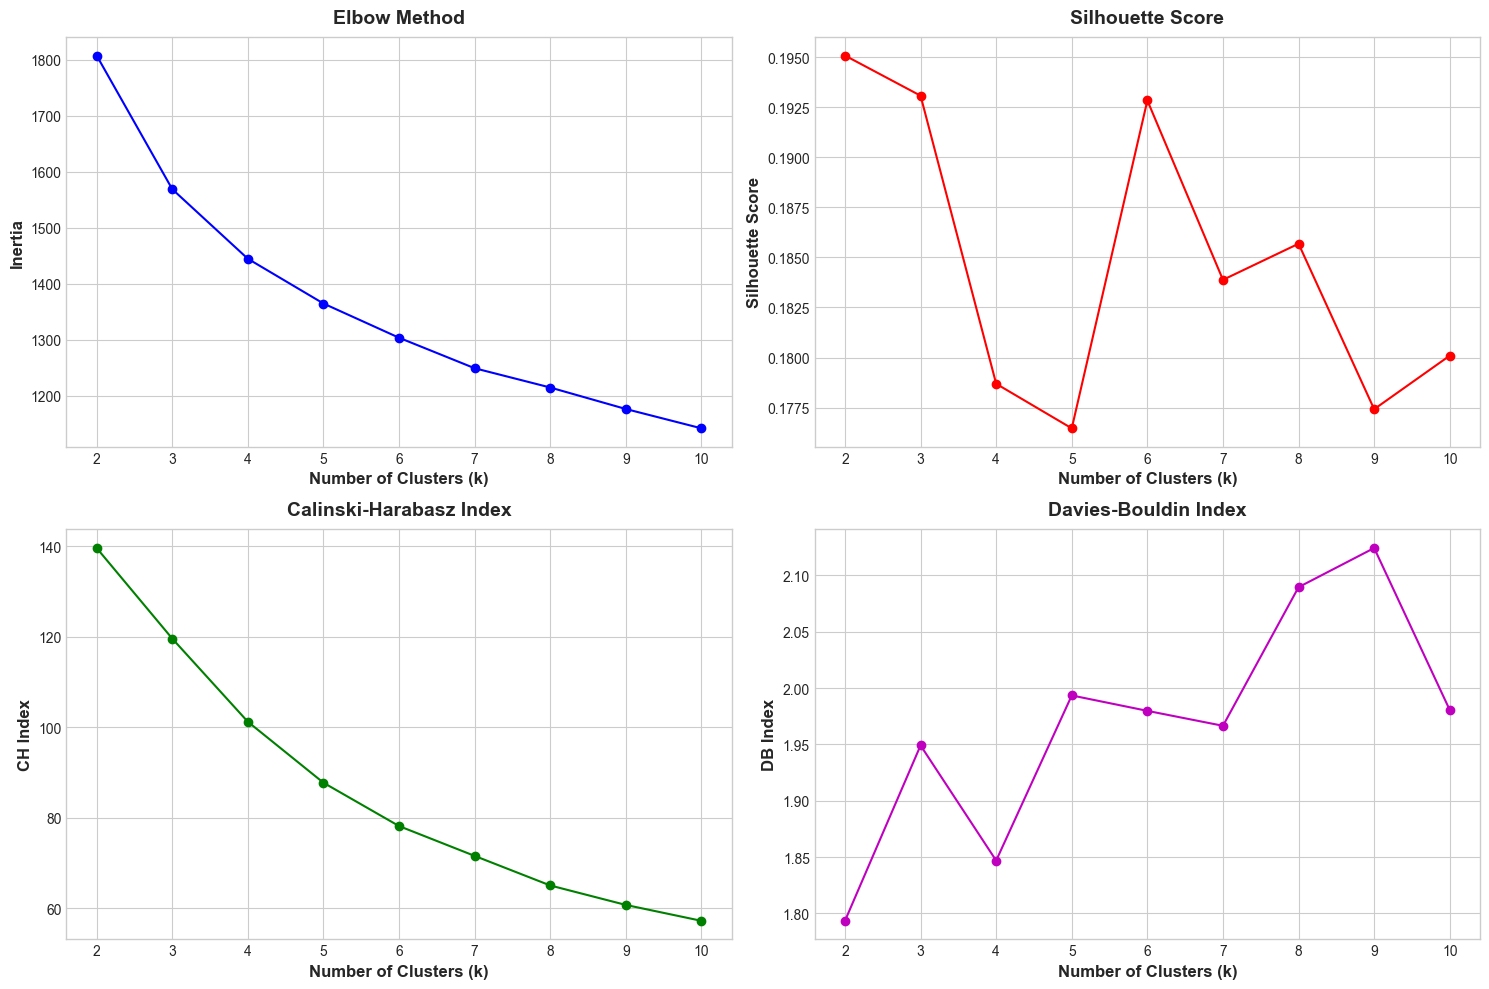

In [45]:
# ===== EVALUACIÓN ÓPTIMA DE CLUSTERS =====

def evaluate_clusters(features, k_range=(2, 11)):
    results = {
        'k': [],
        'inertia': [],
        'silhouette': [],
        'calinski_harabasz': [],
        'davies_bouldin': []
    }
    
    for k in range(k_range[0], k_range[1]):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(features)
        
        results['k'].append(k)
        results['inertia'].append(kmeans.inertia_)
        results['silhouette'].append(silhouette_score(features, cluster_labels))
        results['calinski_harabasz'].append(calinski_harabasz_score(features, cluster_labels))
        results['davies_bouldin'].append(davies_bouldin_score(features, cluster_labels))

    return pd.DataFrame(results)

def plot_cluster_metrics(df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0,0].plot(df['k'], df['inertia'], 'bo-')
    axes[0,0].set_title('Elbow Method')
    axes[0,0].set_xlabel('Number of Clusters (k)')
    axes[0,0].set_ylabel('Inertia')
    axes[0,0].grid(True)
    
    axes[0,1].plot(df['k'], df['silhouette'], 'ro-')
    axes[0,1].set_title('Silhouette Score')
    axes[0,1].set_xlabel('Number of Clusters (k)')
    axes[0,1].set_ylabel('Silhouette Score')
    axes[0,1].grid(True)
    
    axes[1,0].plot(df['k'], df['calinski_harabasz'], 'go-')
    axes[1,0].set_title('Calinski-Harabasz Index')
    axes[1,0].set_xlabel('Number of Clusters (k)')
    axes[1,0].set_ylabel('CH Index')
    axes[1,0].grid(True)
    
    axes[1,1].plot(df['k'], df['davies_bouldin'], 'mo-')
    axes[1,1].set_title('Davies-Bouldin Index')
    axes[1,1].set_xlabel('Number of Clusters (k)')
    axes[1,1].set_ylabel('DB Index')
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()

cluster_metrics = evaluate_clusters(diabetes_features)
plot_cluster_metrics(cluster_metrics)

#### **Análisis de Resultados y Selección de K**

**k=3 seleccionado** basado en:
- Elbow method: punto de inflexión óptimo
- Balance interpretabilidad-granularidad clínica
- Silhouette competitivo (0.193)

**k=6 como alternativa** por mayor silhouette score (0.193).

## **Validación Bootstrap**

Bootstrap es una técnica de remuestreo que evalúa estabilidad y confiabilidad del clustering K-Means mediante la generación de múltiples muestras aleatorias con reemplazo del dataset original.

**Implementación:**  Evaluación de estabilidad con 1000 iteraciones.

In [46]:
# ===== BOOTSTRAP =====
def bootstrap_clustering_validation(features, n_clusters=3, n_iterations=1000, random_state=42):
    np.random.seed(random_state)
    
    metrics = {
        'silhouette': [],
        'calinski_harabasz': [],
        'davies_bouldin': []
    }
    
    for i in range(n_iterations):
        n_samples = len(features)
        bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        features_bootstrap = features.iloc[bootstrap_indices] if hasattr(features, 'iloc') else features[bootstrap_indices]
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=i, n_init=10)
        cluster_labels = kmeans.fit_predict(features_bootstrap)

        metrics['silhouette'].append(silhouette_score(features_bootstrap, cluster_labels))
        metrics['calinski_harabasz'].append(calinski_harabasz_score(features_bootstrap, cluster_labels))
        metrics['davies_bouldin'].append(davies_bouldin_score(features_bootstrap, cluster_labels))

    return metrics

def bootstrap_cluster_stability(features, n_clusters=3, n_iterations=100, random_state=42):
    np.random.seed(random_state)
    
    original_kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    original_labels = original_kmeans.fit_predict(features)

    stability_scores = []
    
    for i in range(n_iterations):
        n_samples = len(features)
        bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        features_bootstrap = features.iloc[bootstrap_indices] if hasattr(features, 'iloc') else features[bootstrap_indices]

        kmeans_boot = KMeans(n_clusters=n_clusters, random_state=i)
        boot_labels = kmeans_boot.fit_predict(features_bootstrap)

        original_subset = original_labels[bootstrap_indices]
        similarity = adjusted_rand_score(original_subset, boot_labels)
        stability_scores.append(similarity)
    
    return np.array(stability_scores)

def plot_bootstrap_distributions(metrics, stability):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    for i, (metric_name, values) in enumerate(metrics.items()):
        if i < 3:
            row, col = i // 2, i % 2
            ax = axes[row, col]
            
            ax.hist(values, bins=30, alpha=0.7, edgecolor='black')
            mean_val = np.mean(values)
            ax.axvline(mean_val, color='red', linestyle='--', label=f'Media: {mean_val:.3f}')
            
            ax.set_title(f'{metric_name.replace("_", " ").title()}')
            ax.set_xlabel('Valor')
            ax.set_ylabel('Frecuencia')
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    ax = axes[1, 1]
    ax.hist(stability, bins=30, alpha=0.7, edgecolor='black')
    mean_stab = np.mean(stability)
    ax.axvline(mean_stab, color='red', linestyle='--', label=f'Media: {mean_stab:.3f}')
    
    ax.set_title('Estabilidad (ARI)')
    ax.set_xlabel('Adjusted Rand Index')
    ax.set_ylabel('Frecuencia')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

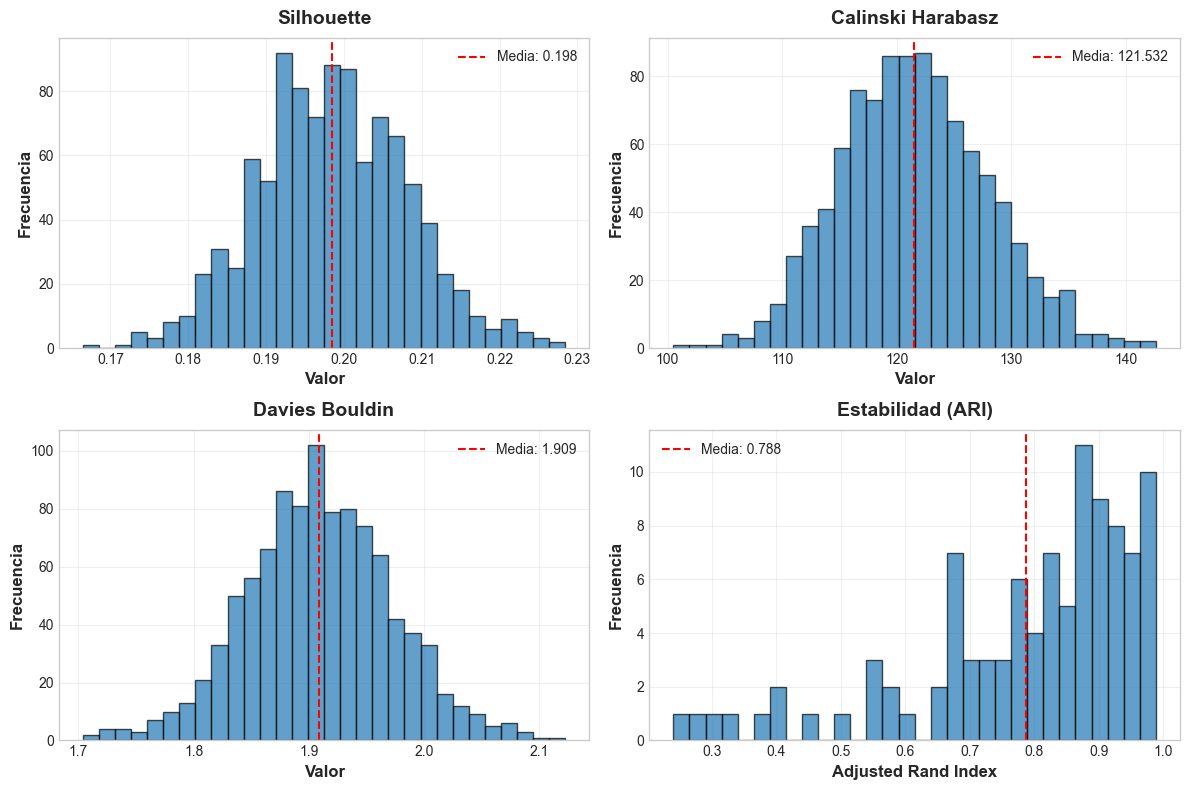

In [47]:
# ===== ANÁLISIS DE CLUSTERING CON BOOTSTRAP =====
bootstrap_metrics = bootstrap_clustering_validation(diabetes_features, n_clusters=3)
bootstrap_stability = bootstrap_cluster_stability(diabetes_features, n_clusters=3)

plot_bootstrap_distributions(bootstrap_metrics, bootstrap_stability)

#### **Resultados Bootstrap:** Clusters validados estadísticamente

Clusters estables (ARI: 0.79) con métricas consistentes.

## **K-Means Clustering**

Aplicación de clustering sin variable género (k=3).

In [64]:
def apply_kmeans_clustering(features, k=3, random_state=42):
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    cluster_labels = kmeans.fit_predict(features)
    return kmeans, cluster_labels

def calculate_cluster_stats(features, cluster_labels, feature_names):
    df = pd.DataFrame(features, columns=feature_names)
    df['cluster'] = cluster_labels
    return df.groupby('cluster').agg(['mean', 'std', 'count'])

def plot_cluster_visualization(features, cluster_labels):
    pca = PCA(n_components=2, random_state=42)
    features_pca = pca.fit_transform(features)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    scatter = ax1.scatter(features_pca[:, 0], features_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
    ax1.set_title('Clustering - PCA Visualization')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.colorbar(scatter, ax=ax1)
    
    unique_labels, counts = np.unique(cluster_labels, return_counts=True)
    ax2.bar(unique_labels, counts, color=['#440154', '#31688e', '#35b779'])
    ax2.set_title('Cluster Size Distribution')
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel('Number of Patients')
    
    total = len(cluster_labels)
    for i, count in enumerate(counts):
        ax2.text(i, count + total*0.01, f'{count}\n({count/total:.1%})', 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return pca.explained_variance_ratio_

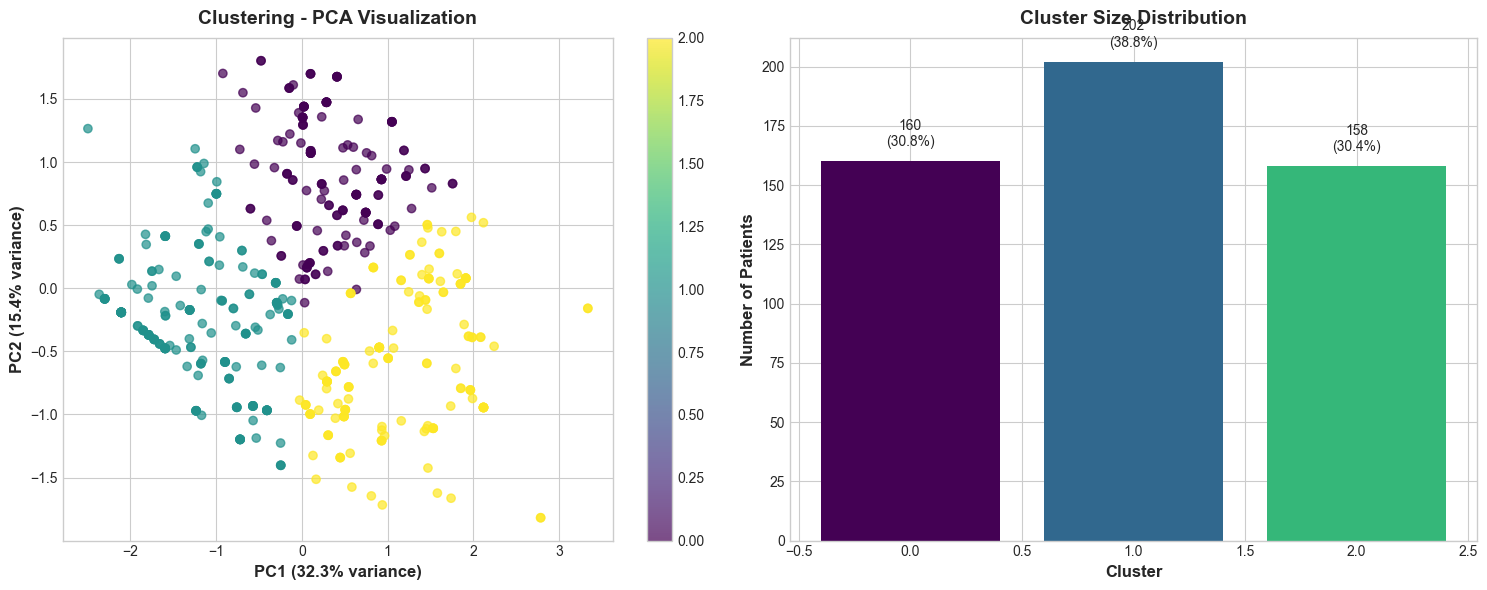

In [67]:
# ===== CLUSTERING K-MEANS =====
clinical_features = diabetes_features.drop('Gender', axis=1)

kmeans_model, cluster_labels = apply_kmeans_clustering(clinical_features, k=3)

silhouette_avg = silhouette_score(clinical_features, cluster_labels)
calinski_score = calinski_harabasz_score(clinical_features, cluster_labels)
davies_bouldin = davies_bouldin_score(clinical_features, cluster_labels)

variance_explained = plot_cluster_visualization(clinical_features, cluster_labels)

feature_names = ['Age'] + binary_symptoms
cluster_stats = calculate_cluster_stats(clinical_features, cluster_labels, feature_names)

#### **Resultados K-Means**

Tres clusters identificados con distribución equilibrada (30%-39%).

## **Análisis Comparativo: K-Means vs Jerárquico**

Evaluación de clustering jerárquico con distancia Hamming para datos binarios.

In [50]:
def hierarchical_clustering_hamming(features, n_clusters=3):
    hamming_distances = pdist(features, metric='hamming')
    distance_matrix = squareform(hamming_distances)
    
    hierarchical = AgglomerativeClustering(
        n_clusters=n_clusters, 
        linkage='average',
        metric='precomputed'
    )
    
    return hierarchical.fit_predict(distance_matrix)

def compare_clustering_methods(kmeans_labels, hierarchical_labels):
    return adjusted_rand_score(kmeans_labels, hierarchical_labels)

def get_cluster_centroids(features, labels, feature_names):
    df = pd.DataFrame(features, columns=feature_names)
    df['cluster'] = labels
    return df.groupby('cluster').mean()



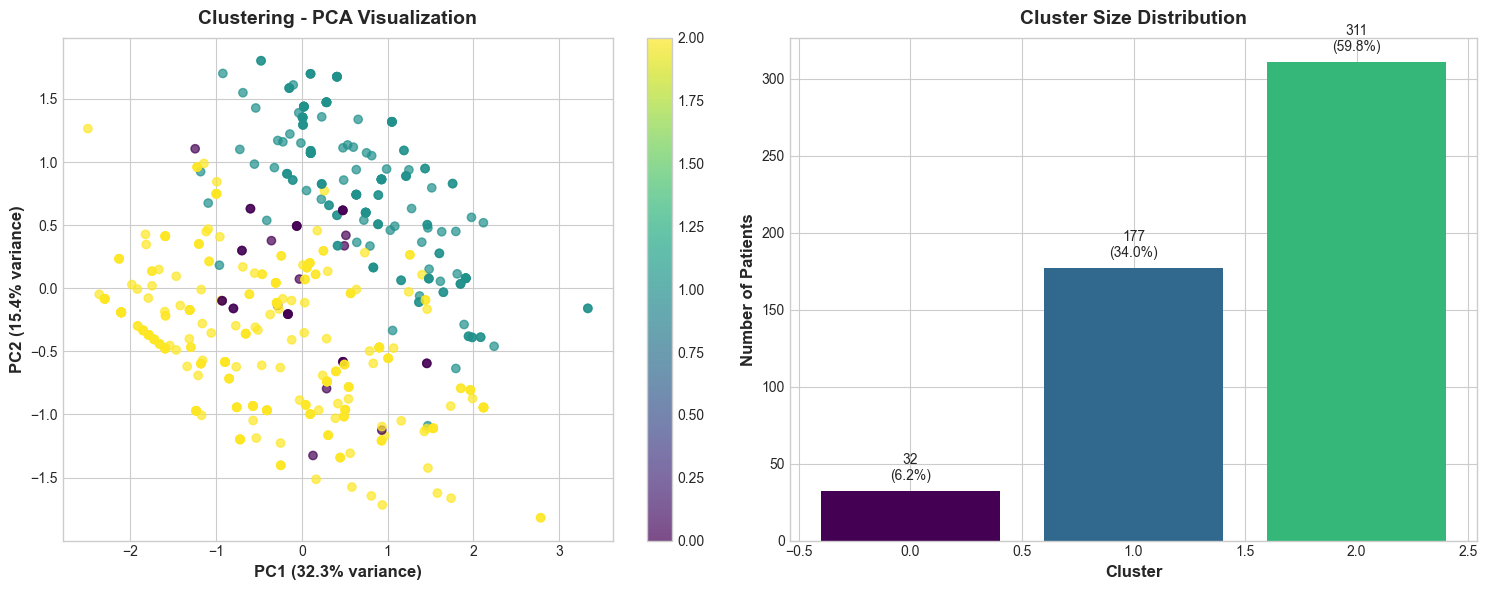

array([0.32329942, 0.1543839 ])

In [65]:
# ===== CLUSTERING JERÁRQUICO =====
hierarchical_labels = hierarchical_clustering_hamming(clinical_features.values)

concordance = compare_clustering_methods(cluster_labels, hierarchical_labels)

kmeans_centroids = get_cluster_centroids(clinical_features, cluster_labels, clinical_features.columns)
hierarchical_centroids = get_cluster_centroids(clinical_features, hierarchical_labels, clinical_features.columns)


plot_cluster_visualization(clinical_features, hierarchical_labels)

#### **Resultados Cluster Jerárquico**

Tres clusters con distribución desbalanceada (6%-60%).


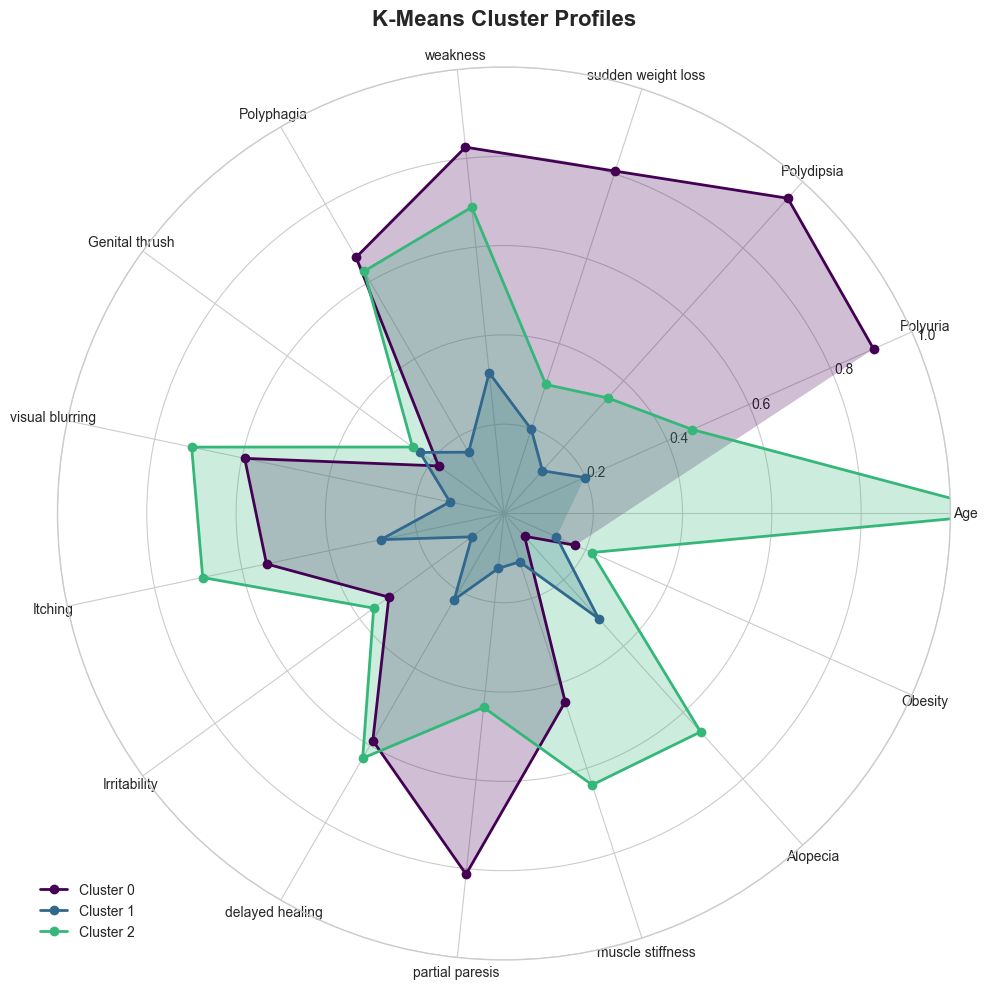

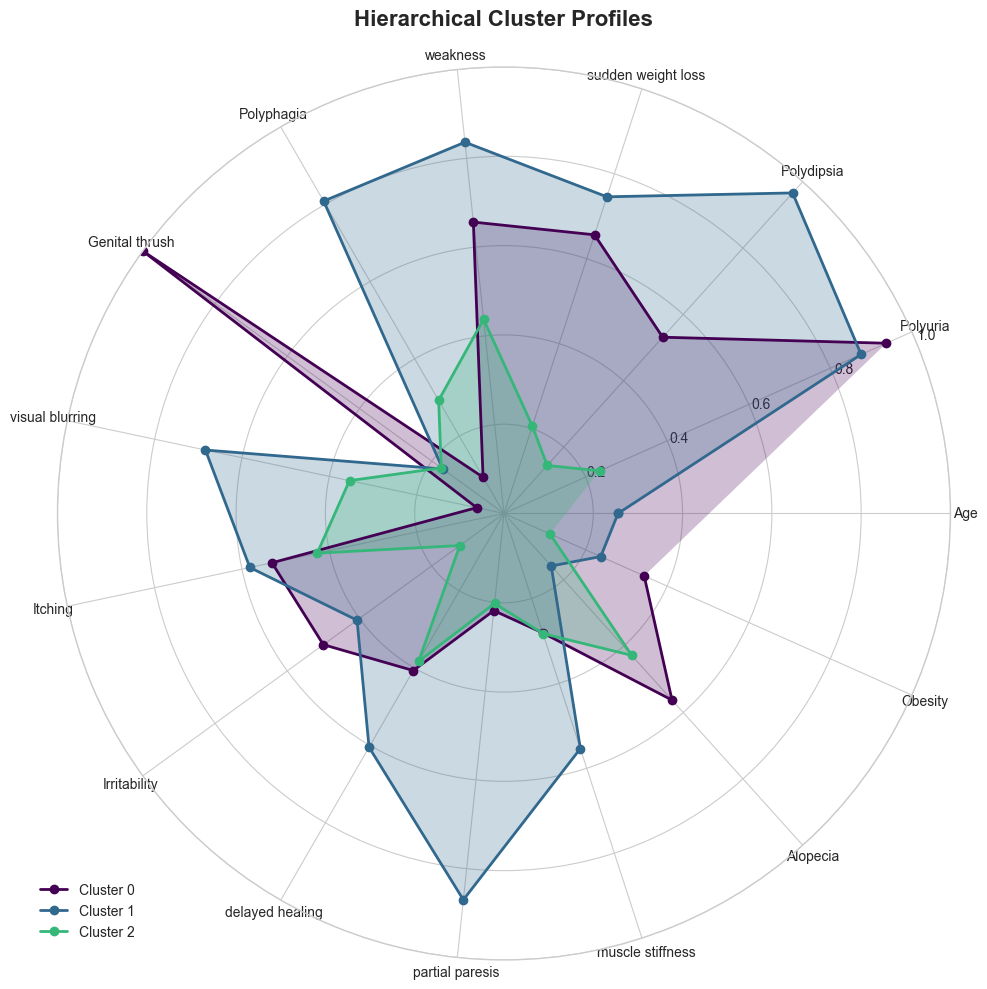

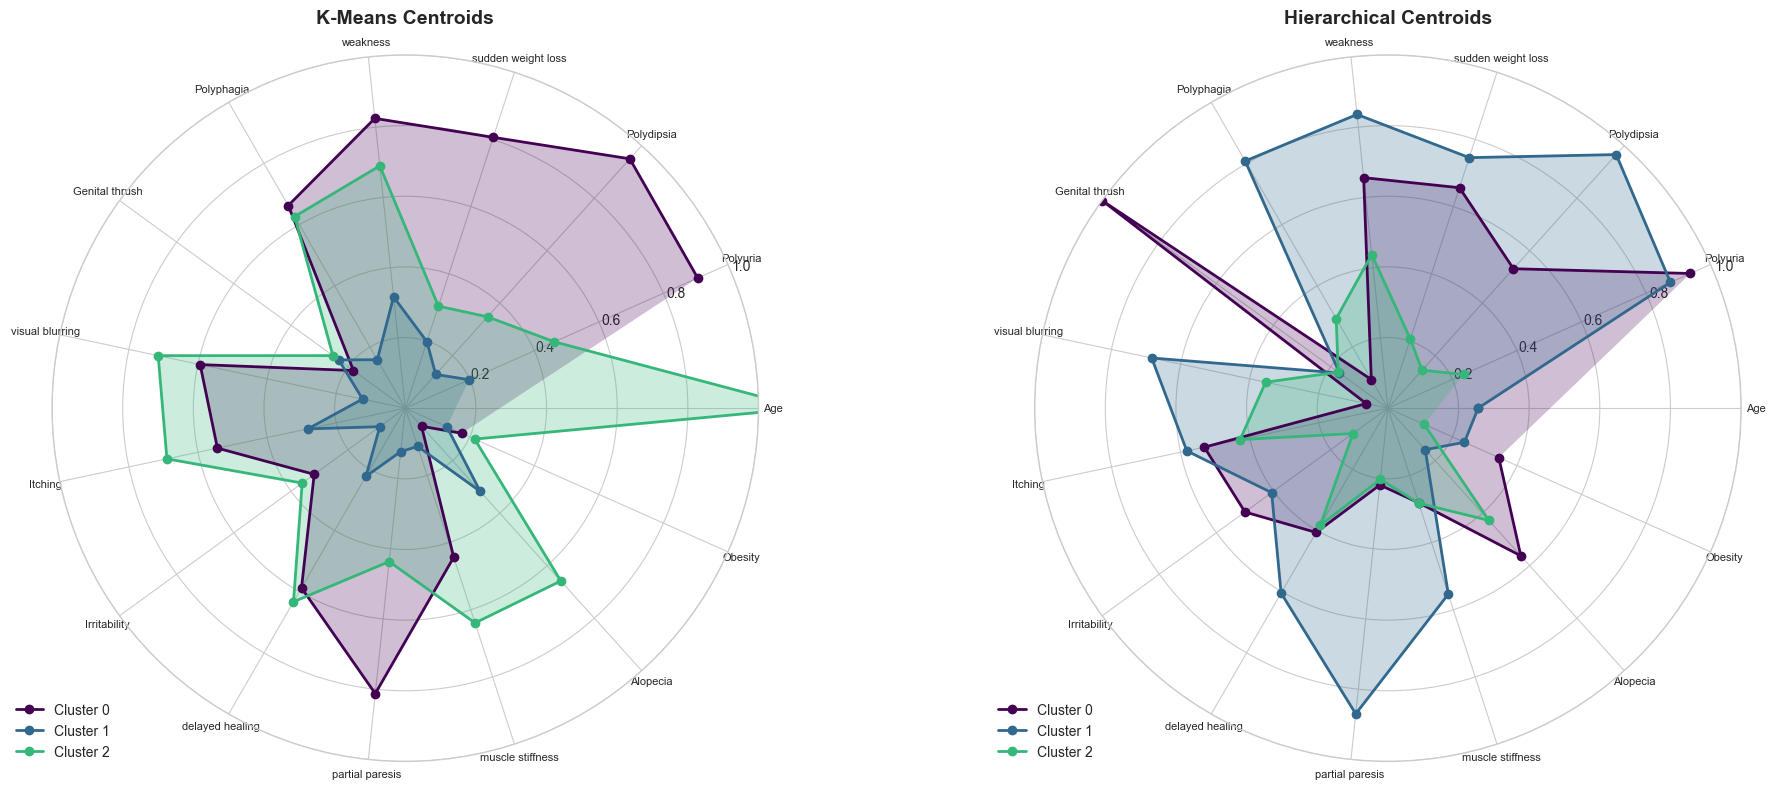

In [52]:
def create_radar_plot(centroids, title, colors=['#440154', '#31688e', '#35b779']):
    features = centroids.columns.tolist()
    n_features = len(features)
    
    angles = np.linspace(0, 2 * np.pi, n_features, endpoint=False).tolist()
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    for i, (cluster_id, values) in enumerate(centroids.iterrows()):
        values_list = values.tolist()
        values_list += values_list[:1]
        
        ax.plot(angles, values_list, 'o-', linewidth=2, 
                label=f'Cluster {cluster_id}', color=colors[i])
        ax.fill(angles, values_list, alpha=0.25, color=colors[i])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, size=10)
    ax.set_ylim(0, 1)
    ax.set_title(title, size=16, fontweight='bold', pad=30)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

def compare_clustering_radar(kmeans_centroids, hierarchical_centroids):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), 
                                   subplot_kw=dict(projection='polar'))
    
    features = kmeans_centroids.columns.tolist()
    n_features = len(features)
    angles = np.linspace(0, 2 * np.pi, n_features, endpoint=False).tolist()
    angles += angles[:1]
    
    colors = ['#440154', '#31688e', '#35b779']
    
    # K-Means
    for i, (cluster_id, values) in enumerate(kmeans_centroids.iterrows()):
        values_list = values.tolist() + values.tolist()[:1]
        ax1.plot(angles, values_list, 'o-', linewidth=2, 
                label=f'Cluster {cluster_id}', color=colors[i])
        ax1.fill(angles, values_list, alpha=0.25, color=colors[i])
    
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(features, size=8)
    ax1.set_ylim(0, 1)
    ax1.set_title('K-Means Centroids', size=14, fontweight='bold')
    ax1.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    ax1.grid(True)
    
    # Jerárquico
    for i, (cluster_id, values) in enumerate(hierarchical_centroids.iterrows()):
        values_list = values.tolist() + values.tolist()[:1]
        ax2.plot(angles, values_list, 'o-', linewidth=2, 
                label=f'Cluster {cluster_id}', color=colors[i])
        ax2.fill(angles, values_list, alpha=0.25, color=colors[i])
    
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(features, size=8)
    ax2.set_ylim(0, 1)
    ax2.set_title('Hierarchical Centroids', size=14, fontweight='bold')
    ax2.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# ===== VISUALIZACIÓN DE RESULTADOS =====
create_radar_plot(kmeans_centroids, 'K-Means Cluster Profiles')
create_radar_plot(hierarchical_centroids, 'Hierarchical Cluster Profiles')
compare_clustering_radar(kmeans_centroids, hierarchical_centroids)

#### **Resultado de comparación**
Se selecciona K-Means como método principal.

## **Clustering Estratificado por Género**

Análisis separado por género para identificar patrones específicos.

In [53]:
def stratified_gender_clustering(features, target, k=3):
    male_mask = features['Gender'] == 1
    
    males_data = features[male_mask].drop('Gender', axis=1)
    females_data = features[~male_mask].drop('Gender', axis=1)

    males_target = target[male_mask]
    females_target = target[~male_mask]
    
    males_model, males_labels = apply_kmeans_clustering(males_data, k)
    females_model, females_labels = apply_kmeans_clustering(females_data, k)
    
    return {
        'males': {
            'features': males_data, 
            'labels': males_labels, 
            'target': males_target  
        },
        'females': {
            'features': females_data, 
            'labels': females_labels, 
            'target': females_target
        }
    }

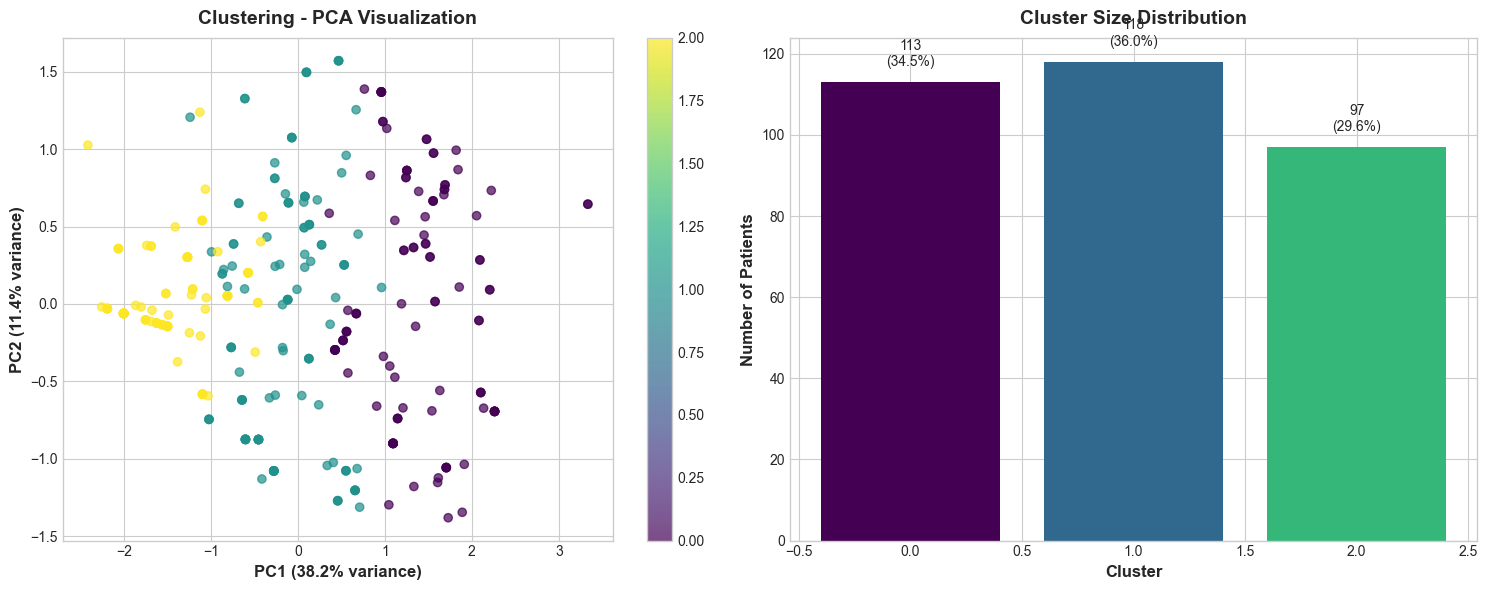

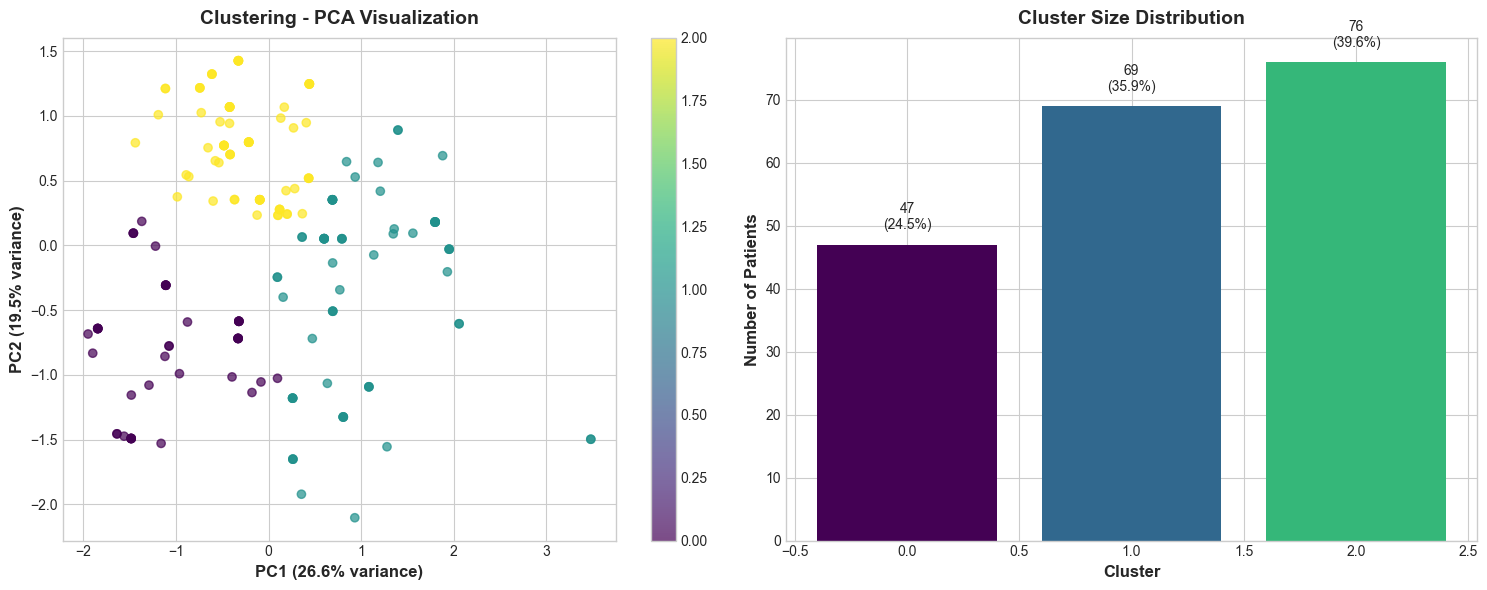

array([0.26585159, 0.19515532])

In [66]:
# ===== CLUSTERING POR GÉNERO =====
gender_results = stratified_gender_clustering(diabetes_features, target)

plot_cluster_visualization(gender_results['males']['features'], gender_results['males']['labels'])
plot_cluster_visualization(gender_results['females']['features'], gender_results['females']['labels'])

#### **Resultado Clustering por Género**

Patrones similares entre géneros con distribuciones balanceadas.

In [55]:
# ===== ANÁLISIS DE PERFILES DE CLUSTERS POR GÉNERO =====
def analyze_gender_cluster_profiles(gender_results):
    for gender in ['males', 'females']:
        gender_name = 'Hombres' if gender == 'males' else 'Mujeres'
        
        features_clean = gender_results[gender]['features']
        labels = gender_results[gender]['labels']
        feature_names = list(features_clean.columns)
        
        print(f"\n{gender_name.upper()}")
        print("="*50)
        
        cluster_stats = calculate_cluster_stats(features_clean.values, labels, feature_names)
        cluster_means = cluster_stats.xs('mean', level=1, axis=1)
        
        for cluster_id in sorted(np.unique(labels)):
            n_patients = np.sum(labels == cluster_id)
            percentage = (n_patients / len(labels)) * 100
            
            print(f"\nCluster {cluster_id} (n={n_patients}, {percentage:.1f}%)")
            print(f"Edad: {cluster_means.loc[cluster_id, 'Age']:.2f}")
            
            symptoms = cluster_means.loc[cluster_id].drop('Age').sort_values(ascending=False)
            
            high_symptoms = symptoms[symptoms > 0.5]
            moderate_symptoms = symptoms[(symptoms > 0.3) & (symptoms <= 0.5)]
            
            if len(high_symptoms) > 0:
                print(f"Síntomas >50%: {', '.join([f'{k}: {v:.1%}' for k, v in high_symptoms.items()])}")
            if len(moderate_symptoms) > 0:
                print(f"Síntomas 30-50%: {', '.join([f'{k}: {v:.1%}' for k, v in moderate_symptoms.items()])}")

analyze_gender_cluster_profiles(gender_results)


HOMBRES

Cluster 0 (n=113, 34.5%)
Edad: 1.12
Síntomas >50%: visual blurring: 85.0%, Polyphagia: 78.8%, weakness: 74.3%, muscle stiffness: 71.7%, partial paresis: 66.4%, delayed healing: 59.3%, Polyuria: 58.4%, Alopecia: 58.4%, Itching: 57.5%
Síntomas 30-50%: Polydipsia: 47.8%, Irritability: 36.3%, sudden weight loss: 35.4%

Cluster 1 (n=118, 36.0%)
Edad: -0.13
Síntomas >50%: Itching: 73.7%, weakness: 68.6%, Alopecia: 62.7%, delayed healing: 58.5%, Genital thrush: 54.2%
Síntomas 30-50%: Polyuria: 44.9%, Polydipsia: 39.8%, sudden weight loss: 38.1%

Cluster 2 (n=97, 29.6%)
Edad: -0.98

MUJERES

Cluster 0 (n=47, 24.5%)
Edad: -0.90
Síntomas 30-50%: visual blurring: 46.8%, weakness: 40.4%, Polyphagia: 36.2%, partial paresis: 31.9%

Cluster 1 (n=69, 35.9%)
Edad: 0.93
Síntomas >50%: Itching: 68.1%, visual blurring: 66.7%, Polyuria: 65.2%, delayed healing: 63.8%, weakness: 60.9%, Polydipsia: 59.4%, sudden weight loss: 59.4%, Polyphagia: 50.7%
Síntomas 30-50%: partial paresis: 49.3%, muscle st

In [56]:
def plot_gender_heatmap_comparison(gender_results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    for i, (gender, ax) in enumerate([('males', ax1), ('females', ax2)]):
        centroids = get_cluster_centroids(
            gender_results[gender]['features'], 
            gender_results[gender]['labels'], 
            gender_results[gender]['features'].columns
        ).drop('Age', axis=1)
        
        sns.heatmap(centroids, annot=True, fmt='.2f', 
                   cmap=['Reds', 'Blues'][i], ax=ax)
        ax.set_title(f'{"Hombres" if gender == "males" else "Mujeres"}')
    
    plt.tight_layout()
    plt.show()

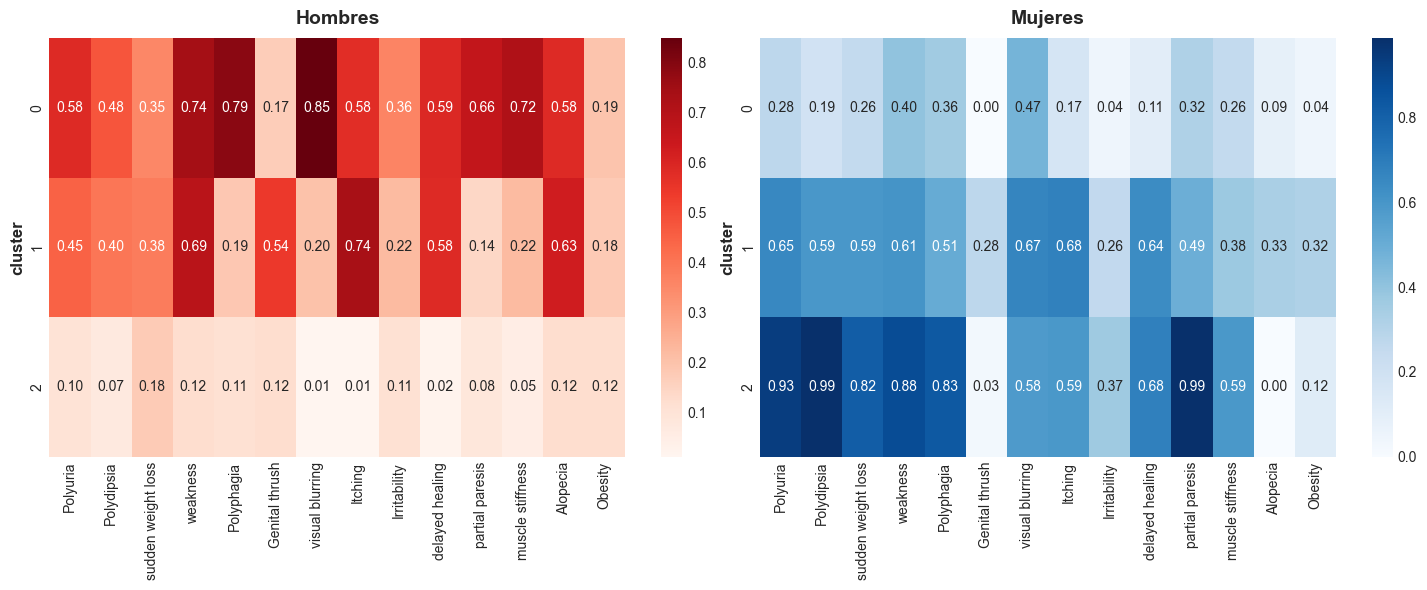

In [57]:
# ===== Visualización heatmap comparativo =====
plot_gender_heatmap_comparison(gender_results)

#### **Perfiles por Género**

Patrones diferenciados: hombres muestran progresión edad-severidad lineal, mujeres presentan mayor variabilidad con extremos asintomático/hiper-severo.

## **Relación Clusters vs Diagnóstico**

Evaluación de asociación entre perfiles sintomatológicos y diagnóstico de diabetes.

In [58]:
def get_cluster_diabetes_distribution(cluster_labels, target):
    df = pd.DataFrame({'cluster': cluster_labels, 'diabetes': target})
    return pd.crosstab(df['cluster'], df['diabetes'], normalize='index')

def plot_cluster_diabetes_relationship(cluster_labels, target):
    distribution = get_cluster_diabetes_distribution(cluster_labels, target)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    distribution.plot(kind='bar', stacked=True, ax=ax, 
                     color=['#C6B2F0', '#FFD190'], alpha=0.8)
    
    ax.set_title('Distribución Diabetes por Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Proporción')
    ax.legend(['No Diabetes', 'Diabetes'])
    ax.set_xticklabels([f'Cluster {i}' for i in distribution.index], rotation=0)
    
    # Añadir porcentajes
    for i, cluster_id in enumerate(distribution.index):
        diabetes_prop = distribution.loc[cluster_id, 'Positive']
        if diabetes_prop > 0.1:
            ax.text(i, 0.5, f'{diabetes_prop:.1%}', 
                   ha='center', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return distribution

def plot_gender_diabetes_comparison(gender_results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    for ax, (gender, data) in zip([ax1, ax2], gender_results.items()):
        distribution = get_cluster_diabetes_distribution(data['labels'], data['target'])
        
        distribution.plot(kind='bar', stacked=True, ax=ax,
                         color=['#C6B2F0', '#FFD190'], alpha=0.8)
        
        title = 'Hombres' if gender == 'males' else 'Mujeres'
        ax.set_title(title)
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Proporción')
        ax.legend(['No Diabetes', 'Diabetes'])
        ax.set_xticklabels([f'C{i}' for i in distribution.index], rotation=0)
    
    plt.tight_layout()
    plt.show()

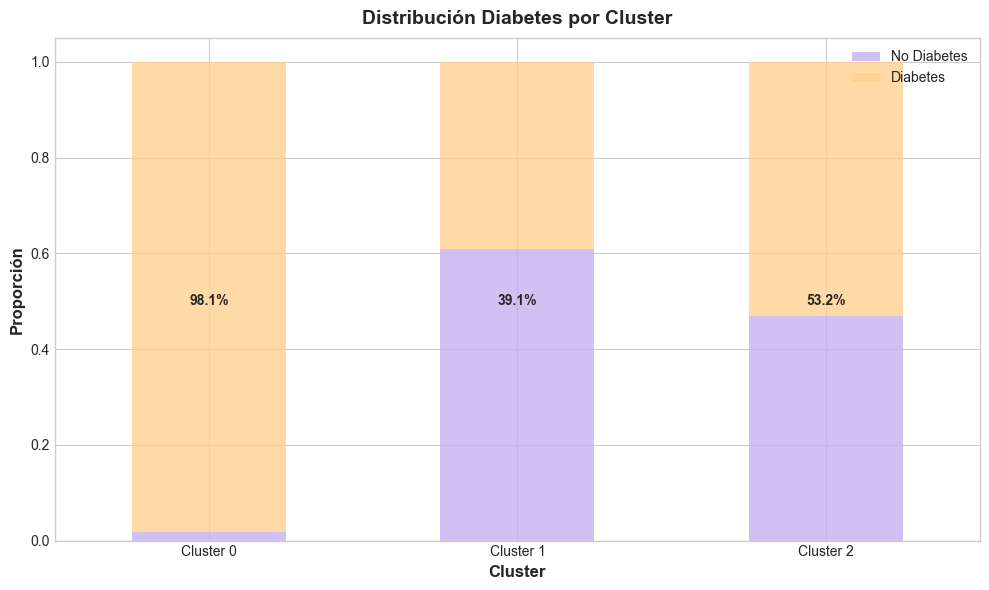


Distribución de Diabetes por Cluster:
diabetes  Negative  Positive
cluster                     
0         0.018750  0.981250
1         0.608911  0.391089
2         0.468354  0.531646


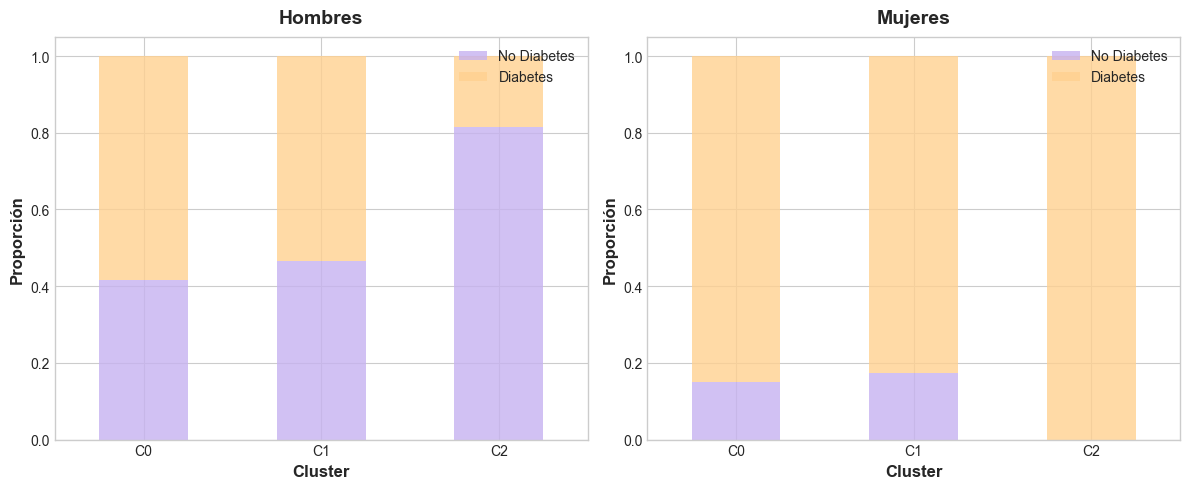

In [59]:
# ===== Relación Clusters vs Diagnóstico =====
diabetes_distribution = plot_cluster_diabetes_relationship(cluster_labels, target)
print("\nDistribución de Diabetes por Cluster:")
print(diabetes_distribution)

# ===== Relación Clusters por Genero vs Diagnóstico =====
plot_gender_diabetes_comparison(gender_results)

#### **Resultado Relación Cluster-Diabetes**

- **Cluster 0**: Alta predictividad diabética (98.1% casos positivos).
- **Clusters 1-2**: Distribución mixta, limitada capacidad predictiva.

Diferencias por género: mujeres muestran mayor concentración diabética en clusters específicos.

# **Conclusiones**

### Clustering Optimal
K-Means con k=3 identificó perfiles sintomatológicos diferenciados y estables (bootstrap ARI: 0.79).

### Perfiles Identificados
- **Cluster 0**: Alta severidad sintomatológica, predictividad diabética 98.1%
- **Cluster 1**: Perfil oligosintomático, distribución mixta diabetes/no-diabetes
- **Cluster 2**: Severidad intermedia, distribución balanceada

### Diferencias por Género
Patrones sintomatológicos similares entre géneros con distribuciones equilibradas. Sin evidencia de perfiles exclusivamente femeninos dermatológicos.

### Validación Metodológica
Clustering jerárquico con distancia Hamming mostró concordancia moderada (ARI: 0.31), se decidio K-Means para estos datos.

### Implicaciones Clínicas
Cluster 0 funciona como biomarcador sintomatológico con alta especificidad diabética, mientras clusters 1-2 requieren evaluación diagnóstica adicional.